# Pipeline Submisson -Microsoft Security Incident Prediction
Can you predict the next big security incident before it happens?

https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction

**Submitted by: Shahar Tavor and Liran Eliav**

## Choosing Dataset:

In [339]:
#pip install pycountry


In [340]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pycountry
import seaborn as sns
from collections import Counter
import json


In [341]:
pd.set_option('display.float_format', '{:,.4f}'.format)

In [342]:
"""
import kagglehub
path = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")
print("Path to dataset files:", path)
"""

'\nimport kagglehub\npath = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")\nprint("Path to dataset files:", path)\n'

## System Stage:

In [343]:
df_train = pd.read_csv("GUIDE_Train.csv")
df_test = pd.read_csv("GUIDE_Train.csv")

### Data size:


In [344]:
print(f"df train shape: {df_train.shape} df test shape: {df_test.shape}")

df train shape: (9516837, 45) df test shape: (9516837, 45)


In [345]:
df_train.head(3)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630


### Data types:


In [346]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [347]:
def describe_df(df):
    rows_count = df.shape[0]
    for col in df.columns:
        print(f"--- Description for column: {col} ---")
        desc = df[col].describe()
        print(desc)
        print()

count: number of non-null entries \
mean: average \
std: standard deviation \
min: minimum \
25%, 50%, 75%: percentiles (quartiles) \
max: maximum



## Meta Data:

### Missing data:

In [348]:
missing_summary = df_train.isnull().sum().to_frame(name='Missing Count')
missing_summary['Missing %'] = (missing_summary['Missing Count'] / len(df_train)) * 100
print(missing_summary[missing_summary['Missing Count'] > 0])


                   Missing Count  Missing %
MitreTechniques          5468386    57.4601
IncidentGrade              51340     0.5395
ActionGrouped            9460773    99.4109
ActionGranular           9460773    99.4109
EmailClusterId           9420025    98.9827
ThreatFamily             9441956    99.2132
ResourceType             9509762    99.9257
Roles                    9298686    97.7077
AntispamDirection        9339535    98.1370
SuspicionLevel           8072708    84.8255
LastVerdict              7282572    76.5230


In [349]:
columns_to_drop = [
    'ActionGrouped', 'ActionGranular', 'EmailClusterId',
    'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
    'SuspicionLevel', 'LastVerdict'
]

In the case of MitreTechniques, its meaningful information, since not having Mitre can connect to clean event.

In [350]:
def clean_df(df):
    print("Before: ",df.shape)
    df['MitreTechniques'] = df['MitreTechniques'].fillna('None')
    df = df.dropna(subset=['IncidentGrade'])
    df = df.drop(columns=columns_to_drop)
    print()
    print("After: ",df.shape)
    return df
    

Clean train:

In [351]:
df_train = clean_df(df_train)

Before:  (9516837, 45)

After:  (9465497, 36)


Clean test:

In [352]:
df_test = clean_df(df_test)

Before:  (9516837, 45)

After:  (9465497, 36)


### Balance the df:

Labels of events are the column 'IncidentGrade':

In [353]:
n_per_class = 100_000

In [354]:
def balance_df(df):
    print("Before balance")
    print(df['IncidentGrade'].value_counts())
    
    df_balanced = pd.concat([
        df[df['IncidentGrade'] == 'BenignPositive'].sample(n=n_per_class, random_state=42),
        df[df['IncidentGrade'] == 'TruePositive'].sample(n=n_per_class//2, random_state=42),
        df[df['IncidentGrade'] == 'FalsePositive'].sample(n=n_per_class//2, random_state=42)
    ])
    
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print()
    print("After balance")
    print(df_balanced['IncidentGrade'].value_counts())
    return df_balanced

balance train:

In [355]:
df_balanced = balance_df(df_train)
df_balanced.shape

Before balance
IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

After balance
IncidentGrade
BenignPositive    100000
TruePositive       50000
FalsePositive      50000
Name: count, dtype: int64


(200000, 36)

balance test:

In [356]:
df_balanced_test = balance_df(df_test)
df_balanced_test.shape

Before balance
IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

After balance
IncidentGrade
BenignPositive    100000
TruePositive       50000
FalsePositive      50000
Name: count, dtype: int64


(200000, 36)

In [357]:
#df_balanced.to_excel("balanced_output.xlsx", index=False)

In [358]:
#df_balanced = pd.read_excel("balanced_output.xlsx")

### Special values:


In [359]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  200000 non-null  int64 
 1   OrgId               200000 non-null  int64 
 2   IncidentId          200000 non-null  int64 
 3   AlertId             200000 non-null  int64 
 4   Timestamp           200000 non-null  object
 5   DetectorId          200000 non-null  int64 
 6   AlertTitle          200000 non-null  int64 
 7   Category            200000 non-null  object
 8   MitreTechniques     200000 non-null  object
 9   IncidentGrade       200000 non-null  object
 10  EntityType          200000 non-null  object
 11  EvidenceRole        200000 non-null  object
 12  DeviceId            200000 non-null  int64 
 13  Sha256              200000 non-null  int64 
 14  IpAddress           200000 non-null  int64 
 15  Url                 200000 non-null  int64 
 16  Ac

Fix timestamp:
We can see the timestamp is object type

In [360]:
# convert to datetime 
df_balanced["Timestamp"] = pd.to_datetime(df_train["Timestamp"], errors='coerce')
df_balanced_test["Timestamp"] = pd.to_datetime(df_balanced_test["Timestamp"], errors='coerce')
df_balanced["Timestamp"].head(3)

0   2024-06-04 06:05:15+00:00
1   2024-06-14 03:01:25+00:00
2   2024-06-13 04:52:55+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]

In [361]:
# check if sorted
is_sorted = df_balanced["Timestamp"].is_monotonic_increasing
print("Is Timestamp sorted?", is_sorted)


Is Timestamp sorted? False


In [362]:
#df_balanced = df_balanced.sort_values("Timestamp").reset_index(drop=True)


In [363]:
ip_freq = df_balanced['IpAddress'].value_counts()
ip_freq

IpAddress
360606    156019
0            213
2            151
8            149
1            142
           ...  
23964          1
110604         1
47516          1
7816           1
84587          1
Name: count, Length: 23104, dtype: int64

We will use the freq of ip:

In [364]:
def map_ip_freq(df):
    df['IpFreq'] = df['IpAddress'].map(ip_freq)
    df['Ip_is_360606'] = (df['IpAddress'] == 360606).astype(int)
    df = df.drop(columns=['IpAddress'])
    return df
        

In [365]:
df_balanced= map_ip_freq(df_balanced)
df_balanced_test = map_ip_freq(df_balanced_test)

## Data Statistics 

#### Country code:

In [366]:
code_to_country = {}
for country in pycountry.countries:
    try:
        code_to_country[int(country.numeric)] = country.name
    except:
        pass

country_map = df_balanced['CountryCode'].map(code_to_country).fillna('Unknown')
country_counts = country_map.value_counts()

In [367]:
#needs to convert to pie

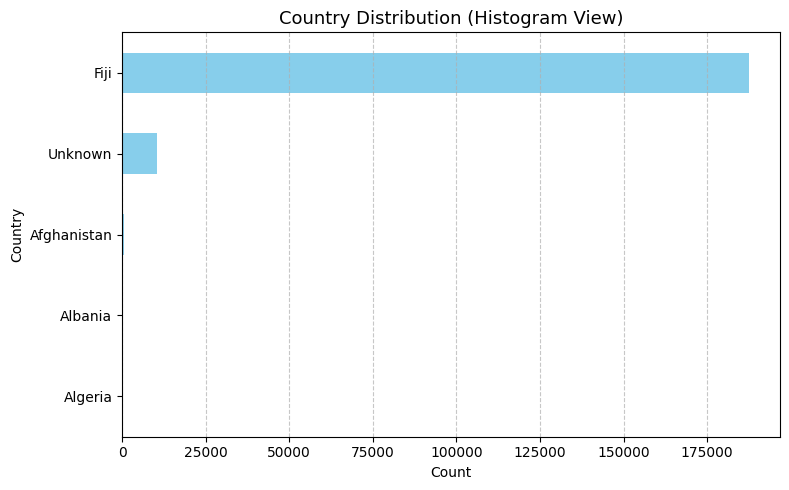

In [368]:
top_n = 5
top_countries = country_counts[:top_n]
other_count = country_counts[top_n:].sum()
plot_country = pd.concat([top_countries])
plt.figure(figsize=(8, 5))
plot_country.sort_values().plot(kind='barh', color='skyblue')
plt.title("Country Distribution (Histogram View)", fontsize=13)
plt.xlabel("Count")
plt.ylabel("Country")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Category and EntityType:

In [369]:
def hist_objest(cat_column):
    column_counts = df_balanced[cat_column].value_counts()
    plt.figure(figsize=(10, 5))
    column_counts.plot(kind='barh', color='skyblue')
    plt.title(f"{cat_column} Distribution")
    plt.xlabel("Count")
    plt.ylabel(f"{cat_column}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

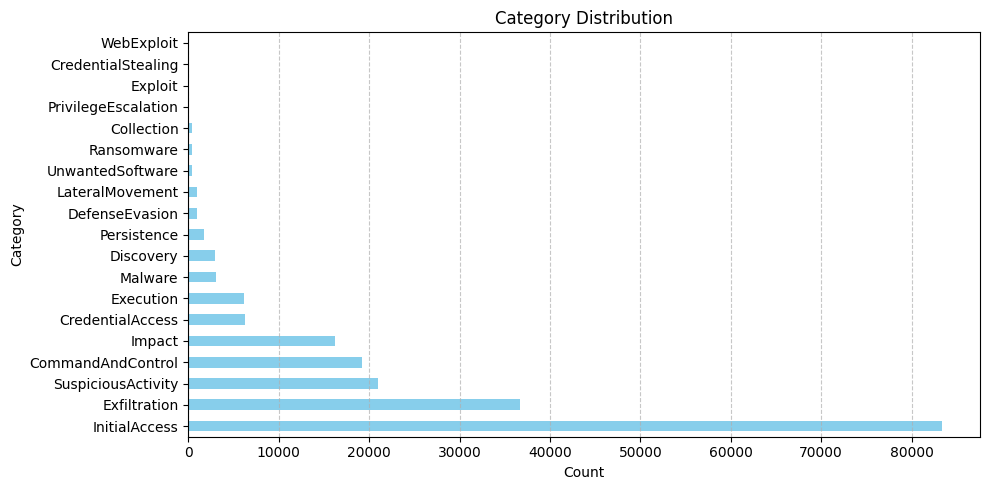

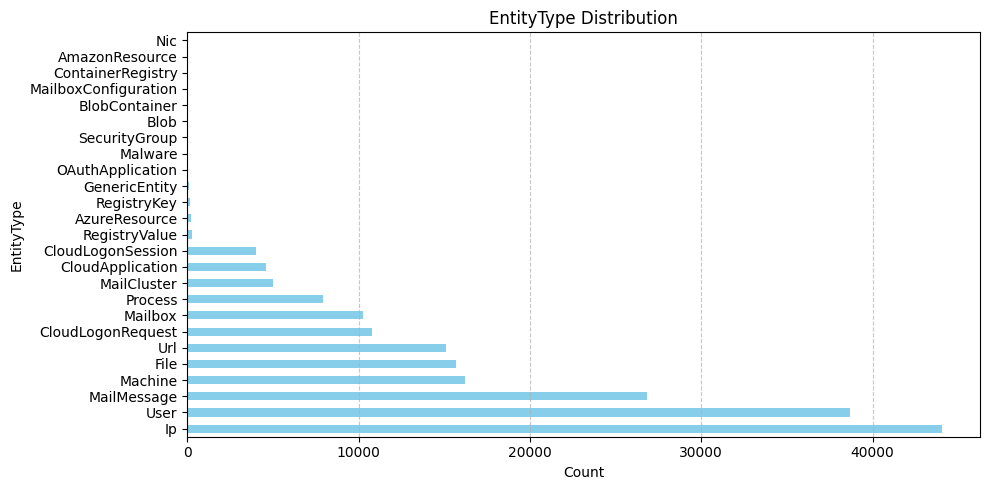

In [370]:
hist_objest("Category")
hist_objest("EntityType")

Map to numeric:

In [371]:
def map_object(df,verbose=False):
    columns_encode = ["Category", "EntityType"]
    le = LabelEncoder()

    for col in columns_encode:
        df[f"{col}_Encode"] = le.fit_transform(df[col])
        label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        if verbose:
            print(f"Label mapping for '{col}':", label_mapping)
            print()
    return df


In [372]:
df_balanced = map_object(df_balanced,verbose=True)

Label mapping for 'Category': {'Collection': 0, 'CommandAndControl': 1, 'CredentialAccess': 2, 'CredentialStealing': 3, 'DefenseEvasion': 4, 'Discovery': 5, 'Execution': 6, 'Exfiltration': 7, 'Exploit': 8, 'Impact': 9, 'InitialAccess': 10, 'LateralMovement': 11, 'Malware': 12, 'Persistence': 13, 'PrivilegeEscalation': 14, 'Ransomware': 15, 'SuspiciousActivity': 16, 'UnwantedSoftware': 17, 'WebExploit': 18}

Label mapping for 'EntityType': {'AmazonResource': 0, 'AzureResource': 1, 'Blob': 2, 'BlobContainer': 3, 'CloudApplication': 4, 'CloudLogonRequest': 5, 'CloudLogonSession': 6, 'ContainerRegistry': 7, 'File': 8, 'GenericEntity': 9, 'Ip': 10, 'Machine': 11, 'MailCluster': 12, 'MailMessage': 13, 'Mailbox': 14, 'MailboxConfiguration': 15, 'Malware': 16, 'Nic': 17, 'OAuthApplication': 18, 'Process': 19, 'RegistryKey': 20, 'RegistryValue': 21, 'SecurityGroup': 22, 'Url': 23, 'User': 24}



In [373]:
df_balanced_test = map_object(df_balanced_test)

#### EvidenceRole:

EvidenceRole indicates the function of an entity (like a device, user) in the context of a security incident\
Impacted entities = primary victims \
Related entities = secondary signals

In [374]:
df_balanced['EvidenceRole'].value_counts()

EvidenceRole
Related     107062
Impacted     92938
Name: count, dtype: int64

Since its binary:

In [375]:
def map_evidence_role(df):
    role_map = {'Related': 0, 'Impacted': 1}
    df['EvidenceRole'] = df['EvidenceRole'].map(role_map)
    return df

In [376]:
df_balanced = map_evidence_role(df_balanced)
df_balanced_test = map_evidence_role(df_balanced_test)

#### IncidentGrade- convert to binary labels

In [377]:
def create_labels(df):
    label_map = {'TruePositive': 1,'FalsePositive': 0,'BenignPositive': 0}
    df['IsIncident'] = df['IncidentGrade'].map(label_map)
    df = df.drop(columns=['IncidentGrade'])
    return df

In [378]:
df_balanced = create_labels(df_balanced)
df_balanced_test = create_labels(df_balanced_test)

#### MitreTechniques:

New feature - count of techniques per row

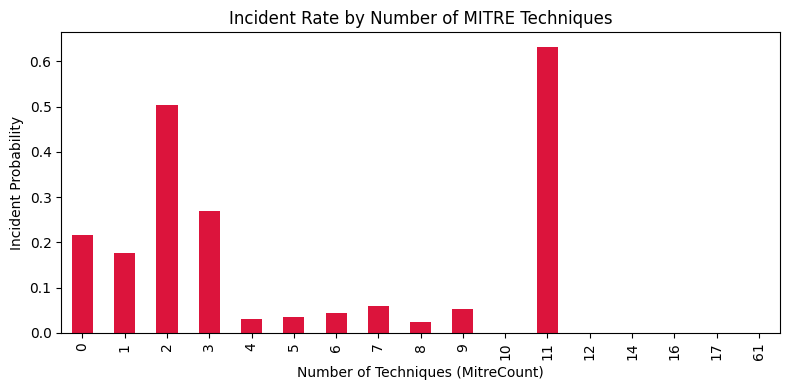

In [379]:
# Group by number of techniques without modifying df
rate = df_balanced['IsIncident'].groupby(
    df_balanced['MitreTechniques'].apply(lambda x: 0 if x == 'None' else len(x.split(';')))
).mean()

# Plot
rate.plot(kind='bar', color='crimson', figsize=(8, 4))
plt.title("Incident Rate by Number of MITRE Techniques")
plt.ylabel("Incident Probability")
plt.xlabel("Number of Techniques (MitreCount)")
plt.tight_layout()
plt.show()



In [380]:
def feature_mitre_count(df):
    df['MitreCount'] = df['MitreTechniques'].apply(
    lambda x: 0 if x == 'None' else len(x.split(';')))
    print(f"Max tech: {df['MitreCount'].max()}, min: {df['MitreCount'].min()}")
    return df

In [381]:
feature_mitre_count(df_balanced)
feature_mitre_count(df_balanced_test)

Max tech: 61, min: 0
Max tech: 61, min: 0


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,...,OSVersion,CountryCode,State,City,IpFreq,Ip_is_360606,Category_Encode,EntityType_Encode,IsIncident,MitreCount
0,704374638309,0,94,333047,2024-06-08 12:55:18+00:00,0,0,InitialAccess,T1078;T1078.004,CloudLogonRequest,...,66,242,1445,10630,156019,1,10,5,1,2
1,1340029797823,32,15591,55721,2024-06-10 13:54:52+00:00,3,4,SuspiciousActivity,None,Url,...,66,242,1445,10630,156019,1,16,23,0,0
2,429496734909,2069,10432,988780,2024-06-13 13:01:28+00:00,4,3,InitialAccess,None,User,...,66,242,1445,10630,156019,1,10,24,0,0
3,1425929144614,48,446629,564277,2024-06-06 18:18:08+00:00,9,45,Execution,None,CloudApplication,...,66,242,1445,10630,156019,1,6,4,0,0
4,1348619731542,43,908,13361,2024-06-16 12:16:32+00:00,1,1,InitialAccess,T1566.002,Mailbox,...,66,242,1445,10630,156019,1,10,14,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,627065230147,190,8832,93988,2024-06-05 00:25:58+00:00,6,5,InitialAccess,T1566,MailMessage,...,66,242,1445,10630,156019,1,10,13,1,1
199996,1151051238707,62,489831,1421092,2024-06-16 04:22:31+00:00,5,39,SuspiciousActivity,None,CloudApplication,...,66,242,1445,10630,156019,1,16,4,1,0
199997,214748366557,0,87,1272103,2024-06-06 05:42:04+00:00,0,0,InitialAccess,T1078;T1078.004,Ip,...,66,13,24,25,24,0,10,10,1,2
199998,240518172813,1437,5444,42389,2024-06-13 00:58:49+00:00,1,1,InitialAccess,T1566.002,Url,...,66,242,1445,10630,156019,1,10,23,1,1


Map tech code to name:

In [382]:
with open("enterprise-attack.json", "r") as f:
    mitre_data = json.load(f)

In [383]:
techniques = {
    obj['external_references'][0]['external_id']: obj['name']
    for obj in mitre_data['objects']
    if obj.get('type') == 'attack-pattern' and 'external_references' in obj
}
for i, (tech, name) in enumerate(techniques.items()):
    print(f"{tech}: {name}")
    if i == 2:
        break

T1055.011: Extra Window Memory Injection
T1053.005: Scheduled Task
T1205.002: Socket Filters


In [384]:
# Flatten technique-label pairs
tech_rows = []
for mitres, label in zip(df_balanced['MitreTechniques'], df_balanced['IsIncident']):
    if mitres != 'None':
        for t in mitres.split(';'):
            tech_rows.append((t, label))

# df of Technique and IsIncident
tech_df = pd.DataFrame(tech_rows, columns=['Technique', 'IsIncident'])
tech_df.head(3)

,Technique,IsIncident
0,T1078,1
1,T1078.004,1
2,T1566.002,0


RowCount- how many times the technique appears, IncidentRate is sum of 'IsIncident'/RowCount

In [385]:
# Compute count and incident rate
summary = tech_df.groupby('Technique')['IsIncident'].agg(['count', 'mean'])
summary.columns = ['RowCount', 'IncidentRate']
summary = summary.sort_values(by='IncidentRate', ascending=False)
summary.head(3)

,RowCount,IncidentRate
Technique,,
T1056.003,1,1.0000
T1578,1,1.0000
T0858,1,1.0000


In [386]:
high_signal = summary[(summary['IncidentRate'] >= 0.7) & (summary['RowCount'] >= 4)]
high_signal.head(10)

,RowCount,IncidentRate
Technique,,
T1586,130,0.9615
T1584,14,0.9286
T1110.004,24,0.9167
T1589.001,17,0.8235
T1589,18,0.7778
T1110.002,4,0.7500
T1110.003,1811,0.7267
T1110.001,1798,0.7158


In [387]:
low_signal = summary[(summary['IncidentRate'] <= 0.3) & (summary['RowCount'] >= 4)]
low_signal = low_signal[:8]
low_signal

,RowCount,IncidentRate
Technique,,
T1566.002,17328,0.2593
T0865,4,0.2500
T1218.002,12,0.2500
T1102,30,0.2333
T1505.003,13,0.2308
T1564,23,0.2174
T1213,14,0.2143
T1574.011,43,0.2093


Create one-hot encoding of the top10 mite:

In [388]:
combined_techniques = high_signal.index.tolist() + low_signal.index.tolist()
combined_techniques = [tid for tid in combined_techniques if tid in techniques] ## keep only if match a technique
 
for tid in combined_techniques:
    name = techniques[tid]
    safe_name = name.replace(' ', '_').replace('.', '_')
    col_name = f'Mitre_{safe_name}'

    df_balanced[col_name] = df_balanced['MitreTechniques'].apply(
        lambda x: int(tid in str(x).split(';')) if pd.notnull(x) else 0
    )


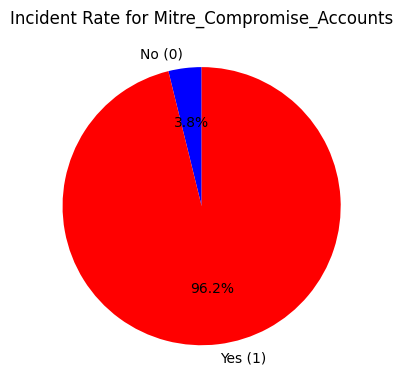

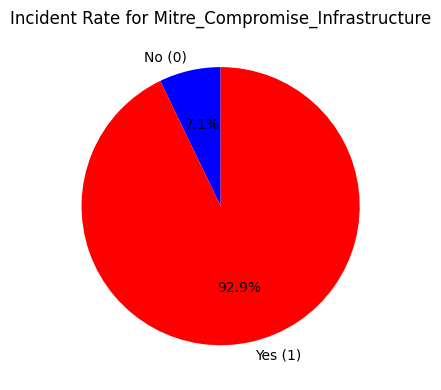

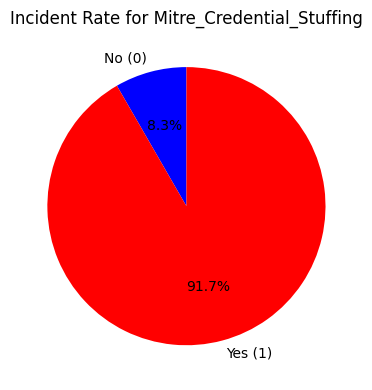

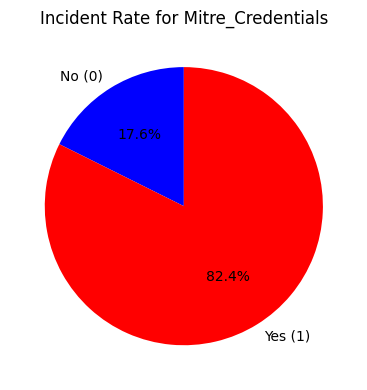

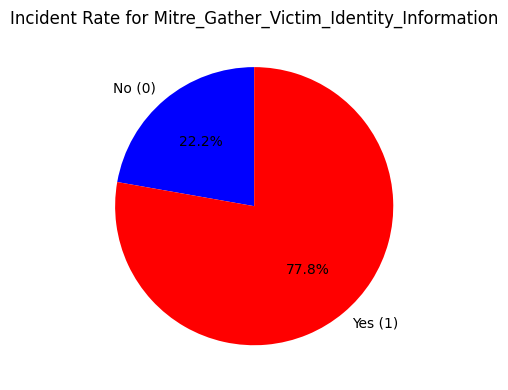

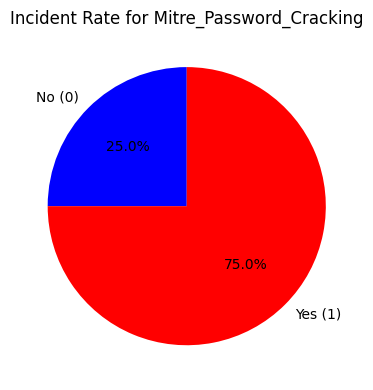

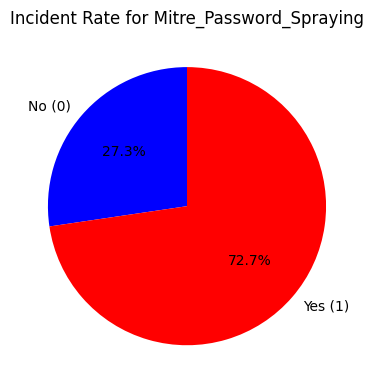

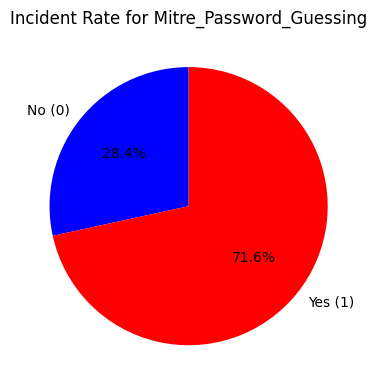

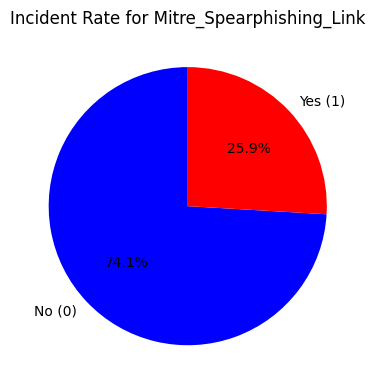

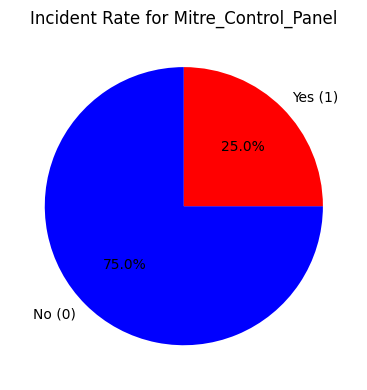

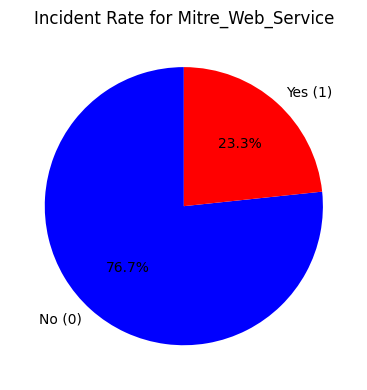

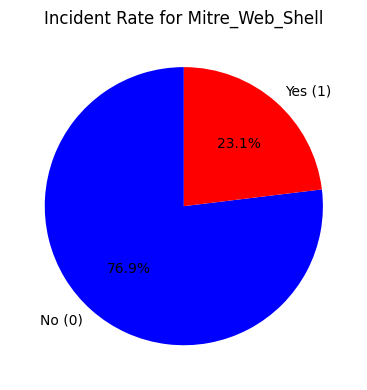

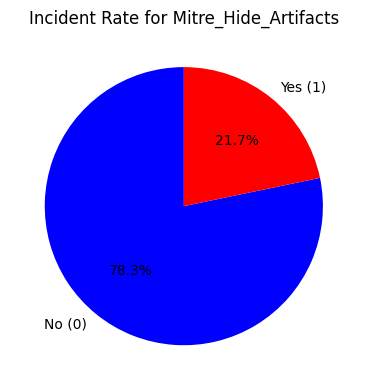

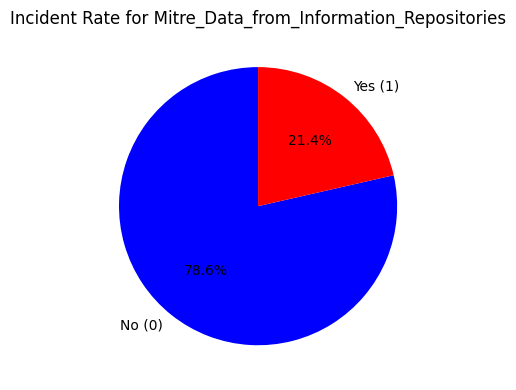

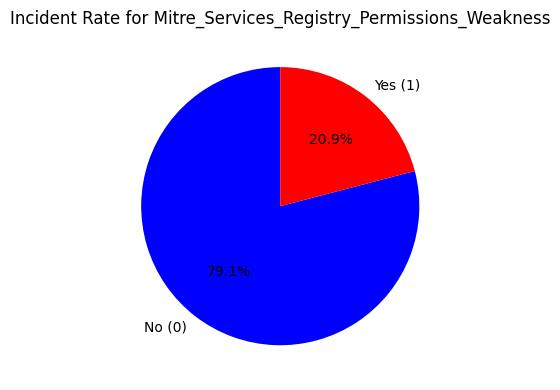

In [389]:
# Build exact column names from selected_techs
selected_col_names = [f"Mitre_{techniques.get(t, t).replace(' ', '_')}" for t in combined_techniques]

# Plot each
for col in selected_col_names:
    subset = df_balanced[df_balanced[col] == 1]
    counts = subset['IsIncident'].value_counts().sort_index()
    counts = counts.reindex([0, 1], fill_value=0)

    labels = ['No (0)', 'Yes (1)']
    colors = ['blue', 'red']

    plt.figure(figsize=(4, 4))
    plt.pie(
        counts,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Incident Rate for {col}")
    plt.tight_layout()
    plt.show()


Convert top10 to new features:

In [390]:
def plot_incident_distribution(df, column, top_n=10):
    # Filter top N values in the column
    top_vals = df[column].value_counts().nlargest(top_n).index
    filtered = df[df[column].isin(top_vals)]

    plt.figure(figsize=(10, 6))
    sns.countplot(data=filtered, x=column, hue='IsIncident', palette={1: 'red', 0: 'blue'})
    plt.title(f"Distribution of IsIncident by {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="IsIncident", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()


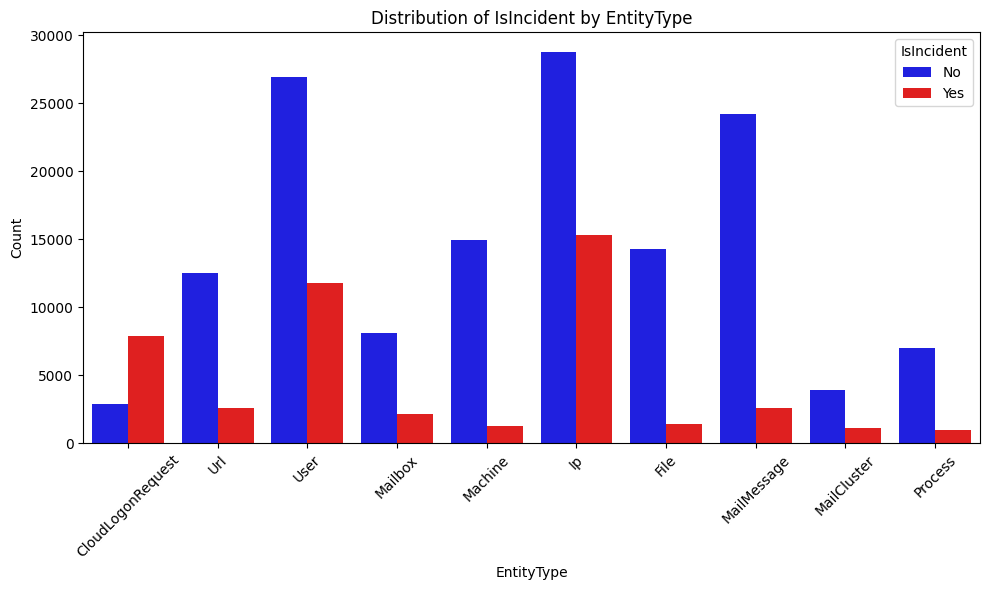

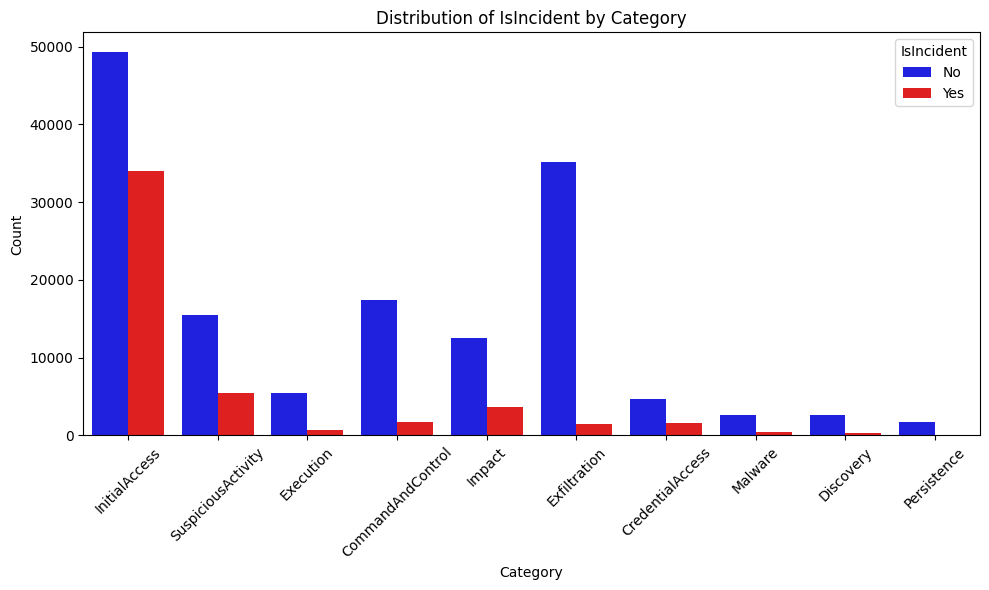

In [391]:
plot_incident_distribution(df_balanced, 'EntityType')
plot_incident_distribution(df_balanced, 'Category')

1. Incidents are most frequently associated with Ip and CloudLogonRequest.
2. MitreCount = 2–3  and 11 is most predictive of true incidents




## Abnormality Detection:

## Clustering:

## Segments:

## NLP:

## Graphs: (also in statistics)

## Models:

## Report:

## Improve: